# Statistics 3: More about Tests, Confidence Intervals, Goodness of Fit, and Model Validation

## More about the t-Test
- Far more to t-tests than evaluating vague differences in distributions
- What about testing if one distribution is significantly greater than/less than another?

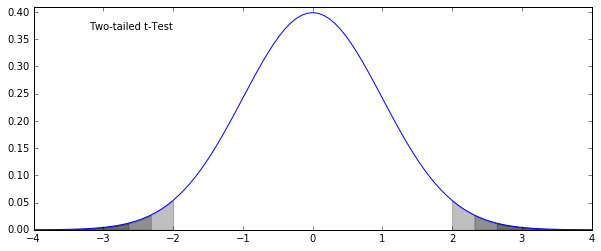

In [1]:
from scipy.stats import norm # scipy's normal distribution module
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

fig = plt.figure(figsize=(10, 4))
x = np.linspace(-4, 4, 101)
y = norm.pdf(x) # probability density function

pct95_1 = x < norm.ppf(0.025); pct975_1 = x < norm.ppf(0.0125); pct99_1 = x < norm.ppf(0.005)
pct95_2 = x > norm.ppf(0.975); pct975_2 = x > norm.ppf(0.9875); pct99_2 = x > norm.ppf(0.995)

ax = plt.subplot(111)
ax.plot(x, y)
opacity = 0.25
shading = "k"
sections = [pct95_1, pct95_2, pct975_1, pct975_2, pct99_1, pct99_2]
for section in sections:
    ax.fill_between(x[section], np.zeros(sum(section)), y[section], color=shading, alpha=opacity)
    
ax.text(0.1, 0.9, "Two-tailed t-Test", transform=ax.transAxes)
ax.set_ylim(0, 0.41)
plt.show()

`numpy.zeros(N)` produces an array of length N filled with zeros.

## One and Two-Tailed t-Tests
- <b>Two-tailed</b>: the basic test of difference between two samples (or one sample from the population)
- <b>Left-tailed</b>: testing to see if $\mu_1 < \mu_2$ (reject the hypothesis that $\mu_1 > \mu_2$
- <b>Right-tailed</b>: testing to see if $\mu_1 > \mu_2$ (reject the hypothesis that $\mu_1 < \mu_2$

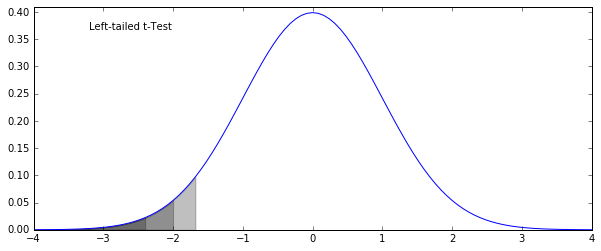

In [2]:
fig = plt.figure(figsize=(10, 4))
x = np.linspace(-4, 4, 101)
y = norm.pdf(x)

pct95 = x < norm.ppf(0.05); pct975 = x < norm.ppf(0.025); pct99 = x < norm.ppf(0.01)
sections = [pct95, pct975, pct99]
ax = plt.subplot(111)
ax.plot(x, y)
for section in sections:
    ax.fill_between(x[section], np.zeros(sum(section)), y[section], color='k', alpha=0.25)
    
ax.text(0.1, 0.9, "Left-tailed t-Test", transform=ax.transAxes)
ax.set_ylim(0, 0.41)
plt.show()

## Example
Is the temperature in Seattle during May significantly cooler than during September?

In [3]:
import pandas as pd
import os

data_dir = "../downloads/seattle_weather/"
weather_files = [
    data_dir + f for f in os.listdir(data_dir) if f.startswith("MonthlyHistory")]
seattle_weather = pd.read_csv(weather_files[0])
rename_these = {}
for col in seattle_weather.columns:
    rename_these[col] = col.replace(" ", "_")
rename_these["Mean_TemperatureF"] = "mean_temp"
seattle_weather.rename(columns=rename_these, inplace=True)

for f in weather_files[1:]:
    indata = pd.read_csv(f)
    rename_these = {}
    for col in indata.columns:
        rename_these[col] = col.replace(" ", "_")
        if col == "PDT":
            rename_these[col] = "PST"
        if col == "Mean TemperatureF":
            rename_these[col] = "mean_temp"
    indata.rename(columns=rename_these, inplace=True)
    seattle_weather = pd.concat((seattle_weather, indata), ignore_index=True)
    
seattle_weather["year"] = seattle_weather.PST.map(lambda x: float(x.split("-")[0]))
seattle_weather["month"] = seattle_weather.PST.map(lambda x: float(x.split("-")[1]))
seattle_weather["day"] = seattle_weather.PST.map(lambda x: float(x.split("-")[2]))

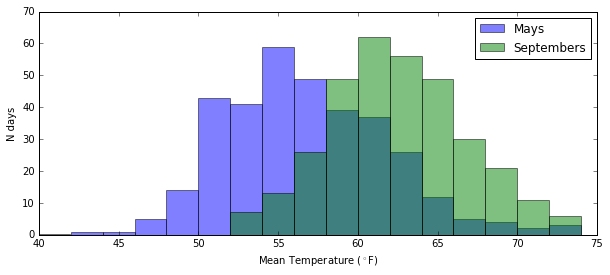

In [4]:
mays = seattle_weather.month == 5
septembers = seattle_weather.month == 9
mean_temp = "mean_temp"

plt.figure(figsize=(10, 4))
plt.hist(seattle_weather[mays][mean_temp], bins=np.arange(40, 76, 2), alpha=0.5, label="Mays")
plt.hist(seattle_weather[septembers][mean_temp], bins=np.arange(40, 76, 2), alpha=0.5, label="Septembers")
plt.legend()
plt.xlabel("Mean Temperature ($^\circ$F)")
plt.ylabel("N days")
plt.show()

In [5]:
from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(seattle_weather[mays]["mean_temp"],
                            seattle_weather[septembers]["mean_temp"])
print("Results:\n\tt-statistic: %.5f\n\tp-value: %g" % (t_stat, p_value / 2))

Results:
	t-statistic: -15.68996
	p-value: 8.98161e-48


We can reject the null hypothesis that between 2002 and 2012 the temperature in Seattle wasn't cooler in May than it was in September. We can reject that hypothesis at the p < 0.01 level. Hell, at the p < 0.00000000001 level. We can tell that it was cooler because the t-statistic is negative (so sample 2's values are consistently larger than sample 1's values)

## Mann-Whitney U-test
- Performs similarly to the t-test
- For when data is significantly <em><b>not</b></em> normally distributed
- **Procedure**:
    - Take both sets of data and rank them together
    - Take the sum of the ranks from the first sample, and compare it to the sizes of each sample

$$U = N_1N_2 + \displaystyle\frac{N_1(N_1 + 1)}{2} - R_1$$

- $R_1$ is the set of ranks for sample 1
- If $U > 0$, sample 1's distribution is to the left of (higher than) sample 2
- If $U > 0 \text{ and } p < \alpha$ then sample 1 is significantly larger than sample 2
- <b>Ref:</b> [scipy.stats.mannwhitneyu](http://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.stats.mannwhitneyu.html)
    - Addressed in the ref, but if you're doing a one-tailed test, multiply the output p-value by 2

## Example: Subway Ridership on Rainy and Non-rainy days
**Hypothesis:** the number of entries per hour in NYC subways is generally different between rainy and non-rainy days

**Null:** there is no difference between rainy and non-rainy days

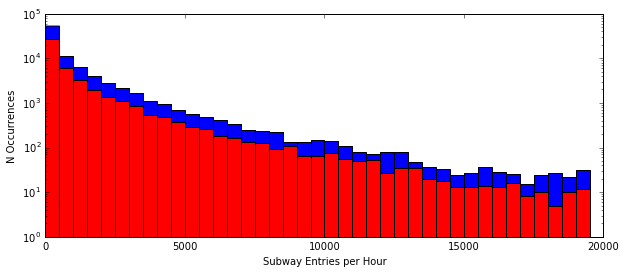

In [6]:
subway_data = pd.read_csv("../downloads/turnstile_data_master_with_weather.csv")
rain = subway_data.rain == 1.0
norain = ~rain

plt.figure(figsize=(10, 4))
plt.hist(subway_data.ENTRIESn_hourly[norain], bins=np.arange(0, 20000, 500), color="b")
plt.hist(subway_data.ENTRIESn_hourly[rain], bins=np.arange(0, 20000, 500), color="r")
plt.xlabel("Subway Entries per Hour")
plt.ylabel("N Occurrences")
plt.yscale("log")
plt.show()

In [7]:
from scipy.stats import mannwhitneyu

u, p = mannwhitneyu(subway_data[rain].ENTRIESn_hourly, subway_data[norain].ENTRIESn_hourly)
print("Results:\n\tU-statistic: %.5f\n\tp-value: %g" % (u, p * 2))

Results:
	U-statistic: 1949994921.00000
	p-value: 0.0999997


We **cannot** reject the null hypothesis there was no difference between ridership. The difference, while there is a difference, is not *statistically* significant.

## Confidence Intervals
- Give a sense of the precision of your estimation
- Not a statement of how much of the data your estimation encompasses
- Not a statement of limits on the range of the true value you're estimating
- Involves standard deviations

$$(x, x + N\cdot\sigma, x - N\cdot\sigma)$$

In [8]:
# back to temperature
import pandasql as sql # for performing SQL queries on DataFrames
import numpy as np

query = """
SELECT 
    main.month, 
    AVG(main.mean_temp) AS avg_monthly_temp,
    AVG((main.mean_temp - sub.avg_temp) * (main.mean_temp - sub.avg_temp)) AS variance
FROM 
    seattle_weather AS main,
    (SELECT AVG(mean_temp) AS avg_temp FROM seattle_weather) AS sub
GROUP BY month
"""
aggregate = sql.sqldf(query, locals())
aggregate # returns a DataFrame

,month,avg_monthly_temp,variance
0,1,42.180645,159.255999
1,2,43.221865,117.551424
2,3,46.067449,73.493650
3,4,50.203030,32.063398
4,5,56.008798,34.556690
5,6,61.421212,96.581061
6,7,66.876833,215.195947
7,8,66.651026,200.143767
8,9,61.769697,93.910744
9,10,53.325513,22.573062


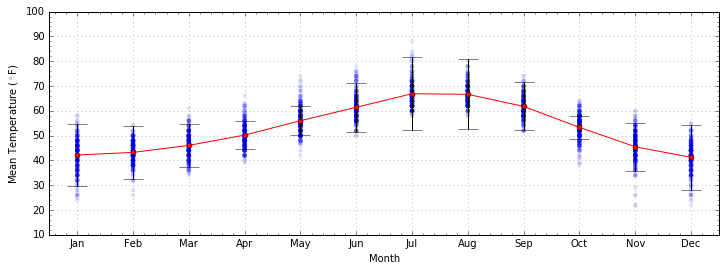

In [9]:
import calendar #just for letting me turn integers 1-12 into month names; doesn't take iterables

month_names = [calendar.month_abbr[ii] for ii in range(1, 13)]
plt.figure(figsize=(12, 4))
ax = plt.subplot(111)
sig = np.sqrt(aggregate.variance)
ax.scatter(seattle_weather.month, seattle_weather.mean_temp, c='b', alpha=0.1, edgecolor="None")
ax.errorbar(aggregate.month, aggregate.avg_monthly_temp, sig, capsize=10, ecolor="k", color='r', ms=5, marker="o")
ax.minorticks_on(); ax.grid(alpha=0.5, color="k")
ax.set_xlim(0.5, 12.5); ax.set_xticks(range(1, 13))
ax.set_xticklabels(month_names); ax.set_xlabel("Month")
ax.set_ylabel("Mean Temperature ($^\circ$F)")
plt.show()

`ax.errorbar` and `plt.errorbar` produce scatter points with errorbars. In this example, the standard deviation for each point sets the error bar for each point.

## Goodness of Fit
- Evaluate your model of the data
- Bias vs variance in model fitting
- The chi-squared statistic:

$$\chi^2_\text{dof} = \displaystyle\frac{1}{N - k}\sum_{i=1}^N\frac{(x - \text{model})^2}{\sigma^2}$$

- *k* degrees of freedom correspond to model constraints
- The goal: 
    - have the difference between my data and my model be, on average, the same as the standard deviation (or uncertainty) of the data
    - **simpler goal:** get $\chi^2_\text{dof} \approx 1$

## Example: Divining the mean temperature by brute force
I want to test a number of temperatures to see which one is closest to the average of the data.

In this exercise, my model is the temperature that I'm testing, so I'm testing a range of models against my data.

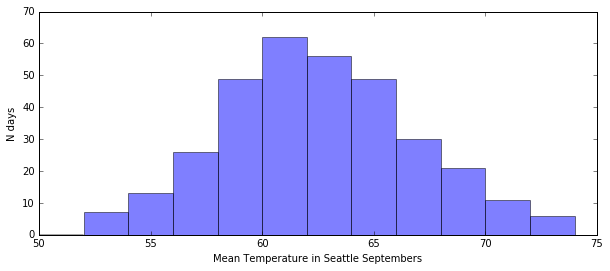

In [10]:
# the data. clearly it peaks between 60 and 64 degrees
plt.figure(figsize=(10, 4))
plt.hist(seattle_weather[septembers]["mean_temp"], bins=np.arange(50, 76, 2), alpha=0.5)
plt.xlabel("Mean Temperature in Seattle Septembers")
plt.ylabel("N days")
plt.show()

In [11]:
# function for chi-squared statistic
def chi_sq(data, model, std, dof=1):
    return sum(((data - model)/std)**2) / (len(data) - dof)

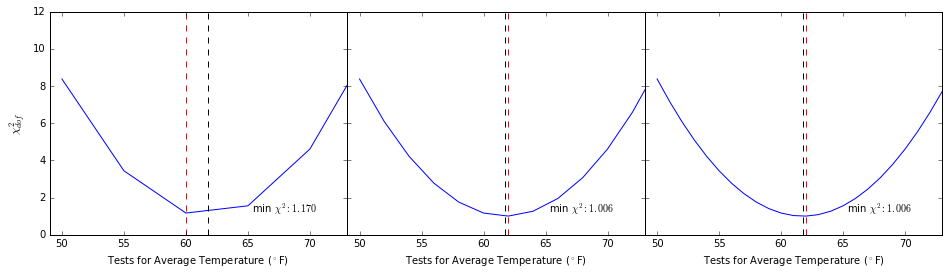

In [12]:
september_temps = seattle_weather[seattle_weather.month == 9]["mean_temp"]
resolution = 5.

fig = plt.figure(figsize=(16, 4))
fig.subplots_adjust(wspace=0)

for ii in range(1, 4):
    ax = plt.subplot(1, 3, ii)    
    test_temps = np.arange(50, 76, 5/ii)
    chi_vals = np.array([chi_sq(september_temps, test, np.std(september_temps)) for test in test_temps])
    ax.plot(test_temps, chi_vals)
    ax.plot([september_temps.mean(), september_temps.mean()], [0, 12], linestyle="--", color='k')
    ax.plot([test_temps[chi_vals.argmin()], test_temps[chi_vals.argmin()]], [0, 12], linestyle="--", color='r')
    ax.text(0.9, 0.1, "min $\chi^2: %.3f$" % min(chi_vals), transform=ax.transAxes, horizontalalignment="right")
    ax.set_xlim(49, 73)
    if ii == 1: ax.set_ylabel("$\chi^2_{dof}$", fontsize=12)
    else: ax.set_yticklabels([])
    ax.set_xlabel("Tests for Average Temperature ($^\circ$F)")

plt.show()

### Note: the model with the best fit you can calculate is not always the best model for the data you have

More about model selection tomorrow!

## Cross Validation
- Model should be able to, to some degree, generate data that looks like the data that created it
    - i.e. model paramters shouldn't change drastically with random cuts of data
- Want to decouple model parameters from distinct variance in the data
- Split data into training and testing sets
- Scikit-learn cross-validates with [sklearn.cross_validation](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.cross_validation):
    - **train_test_split**: split data into two sets, with specified fractions
    - **ShuffleSplit**: split data into <em>N</em> shuffled training/test sets
    - **KFold**: split data into <em>K</em> chunks, and iterate through to validate model using one chunk as the training set and the other <em>K - 1</em> chunks as the test sets
    - **StratifiedKFold**: same thing as K-Fold cross validation, but preserves ratios of labeled data
- A better estimation of confidence intervals; can now base them on the standard deviation of cross-validated parameter estimations

## Example: Estimate Average Temperature in September with Confidence Intervals

In [13]:
import sklearn.cross_validation as cv

mean_temps = []
chi_vals = []
for ii in range(10):
    X_train, X_test = cv.train_test_split(september_temps, test_size=0.33)
    mean_temps.append(np.mean(X_train))
    chi_vals.append(chi_sq(X_test, np.mean(X_train), np.std(X_train)))

In [14]:
the_mean_temp = np.mean(mean_temps)
sig = np.std(mean_temps)
out_str = "Mean Temperature in September: %.2f" % the_mean_temp
out_str += "\n\t68-pct confidence int:\t (%.2f, %.2f)" % (the_mean_temp - sig, the_mean_temp + sig)
out_str += "\n\t95-pct confidence int:\t (%.2f, %.2f)" % (the_mean_temp - 2*sig, the_mean_temp + 2*sig)
out_str += "\n\t99.7-pct confidence int: (%.2f, %.2f)" % (the_mean_temp - 3*sig, the_mean_temp + 3*sig)
out_str += "\n\nThe true mean: %.2f" % np.mean(september_temps)
print(out_str)

Mean Temperature in September: 61.81
	68-pct confidence int:	 (61.68, 61.93)
	95-pct confidence int:	 (61.56, 62.06)
	99.7-pct confidence int: (61.43, 62.19)

The true mean: 61.77


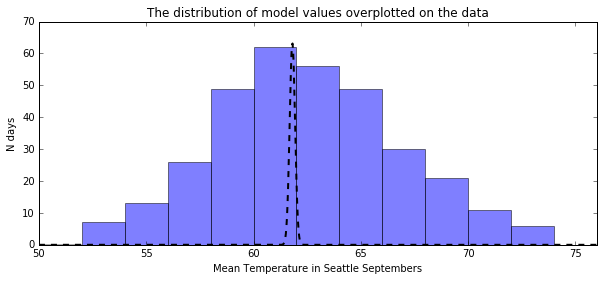

In [15]:
plt.figure(figsize=(10, 4))
plt.title("The distribution of model values overplotted on the data")
plt.hist(september_temps, bins=np.arange(50, 76, 2), alpha=0.5)
x = np.linspace(50, 76, 1000)
plt.plot(x, 20 * norm.pdf(x, the_mean_temp, sig), color='k', linestyle="--", linewidth=2)
plt.xlim(50, 76)
plt.xlabel("Mean Temperature in Seattle Septembers")
plt.ylabel("N days")
plt.show()